Make J-plot from STEREO/SECCHI COR1-A images to track the speed of a solar feature

In [82]:
# %matplotlib notebook
# %matplotlib ipympl
# %matplotlib widget
from ipywidgets import *

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from PIL import Image
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, LogStretch
from scipy import stats
import sunpy.sun.constants as const

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [31]:
start_time = '2024-05-14T16:30:00'
end_time   = '2024-05-14T23:59:59'

START_DATE, START_TIME = start_time.split('T')
END_DATE, END_TIME = end_time.split('T')

START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

data_dir = '/home/mnedal/data'

In [32]:
# read the files names in order
data = sorted(glob.glob(f'{data_dir}/COR1_A/COR1_A_{START_YEAR}{START_MONTH}{START_DAY}*.jp2'))
print(f'\nNumber of fetched images: {len(data)}\n')


Number of fetched images: 450



In [33]:
start_file_to_find = f'{data_dir}/COR1_A/COR1_A_{START_YEAR}{START_MONTH}{START_DAY}T{START_HOUR}{START_MINUTE}.jp2'
end_file_to_find = f'{data_dir}/COR1_A/COR1_A_{START_YEAR}{START_MONTH}{START_DAY}T{END_HOUR}{END_MINUTE}.jp2'

idx1 = data.index(start_file_to_find)
idx2 = data.index(end_file_to_find)

print(f'Index of the first image {start_file_to_find} is {idx1}')
print(f'Index of the last image {end_file_to_find} is {idx2}')

Index of the first image /home/mnedal/data/COR1_A/COR1_A_20240514T1630.jp2 is 0
Index of the last image /home/mnedal/data/COR1_A/COR1_A_20240514T2359.jp2 is 449


In [34]:
map_objects = data[idx1:idx2]
print(len(map_objects))

449


In [133]:
file = map_objects[80]
map_obj = sunpy.map.Map(file)

In [134]:
# # Test ...
# for img in map_objects[40:60]:
#     map_obj = sunpy.map.Map(img)
#     min_range = 0
#     max_range = 200
#     map_obj.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range)

#     fig = plt.figure(figsize=[7,7])
#     ax = fig.add_subplot(111, projection=map_obj)
#     img = map_obj.plot(axes=ax)
#     ax.grid(False)
#     fig.colorbar(img, pad=0.02, shrink=0.8)
#     plt.show()

In [135]:
# map_obj.meta['bunit'] = 'ct' # a workaround for C3 jp2 images
# map_obj.peek()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


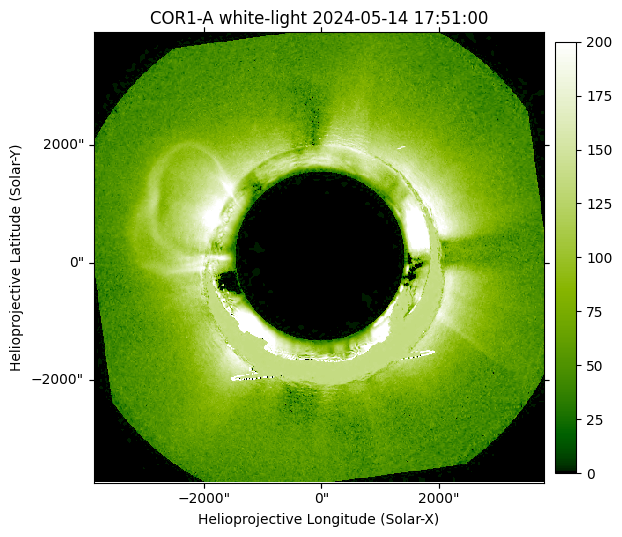

In [136]:
min_range = 0
max_range = 200
map_obj.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=map_obj)
img = map_obj.plot(axes=ax)
ax.grid(False)
fig.colorbar(img, pad=0.02, shrink=0.8)
plt.show()

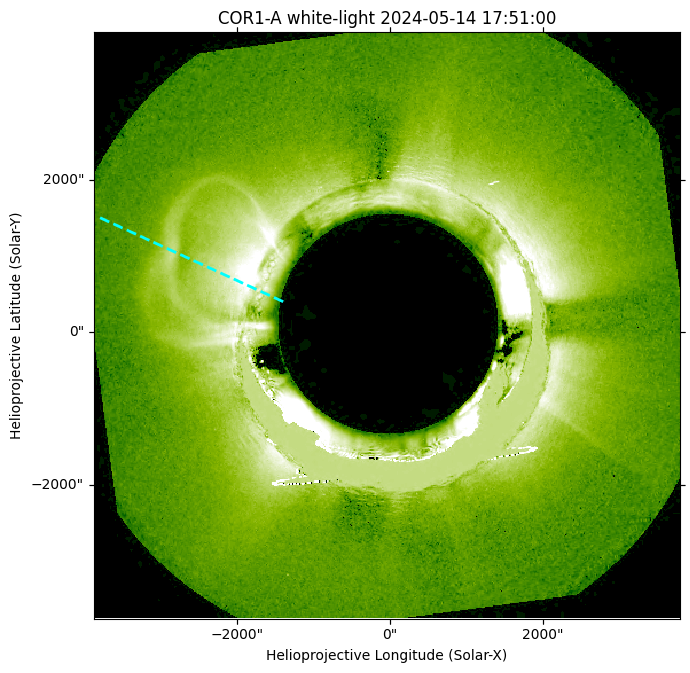

In [143]:
# event_num = 1
# slit_x1 = 1400
# slit_x2 = 3750
# slit_y1 = 0
# slit_y2 = 100

event_num = 2
slit_x1 = -1400
slit_x2 = -3800
slit_y1 = 400
slit_y2 = 1500

slit_coords = SkyCoord(
        Tx=(slit_x1, slit_x2)*u.arcsec,
        Ty=(slit_y1, slit_y2)*u.arcsec,
        frame=map_obj.coordinate_frame)

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=map_obj)
map_obj.plot(axes=ax)
ax.plot_coord(slit_coords, color='cyan', linestyle='--', linewidth=2)
ax.grid(False)
fig.tight_layout()
plt.show()

In [144]:
# loop over the maps to extract the intensity along the slit
intensity_values_slit = []
distances_slit = []
times = []

for i, m in enumerate(map_objects):
    print(f'{i} Working on {m} ..')
    map_obj = sunpy.map.Map(m)
    map_obj.meta['bunit'] = 'ct' # a workaround for C3 jp2 images
    map_obj.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=200)
    
    slit_coords = SkyCoord(
            Tx=(slit_x1, slit_x2)*u.arcsec,
            Ty=(slit_y1, slit_y2)*u.arcsec,
            frame=map_obj.coordinate_frame)
    
    # obtain the coordinates of the map pixels that intersect that path
    intensity_coords_slit = sunpy.map.pixelate_coord_path(map_obj, slit_coords)
    # Pass those coordinates to extract the values for those map pixels
    intensity_slit = sunpy.map.sample_at_coords(map_obj, intensity_coords_slit)
    # Calculate the angular separation between the first point and every other coordinate we extracted
    angular_separation_slit = intensity_coords_slit.separation(intensity_coords_slit[0]).to(u.arcsec)
    # Append the values to the lists
    intensity_values_slit.append(intensity_slit)
    distances_slit.append(angular_separation_slit)
    times.append(map_obj.date.iso)

0 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1630.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
1 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1631.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
2 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1632.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
3 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1633.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the

30 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1700.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
31 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1701.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
32 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1702.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
33 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1703.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of

60 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1730.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
61 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1731.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
62 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1732.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
63 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1733.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of

90 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1800.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
91 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1801.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
92 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1802.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
93 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1803.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of

120 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1830.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
121 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1831.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
122 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1832.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
123 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1833.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

150 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1900.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
151 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1901.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
152 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1902.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
153 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1903.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

180 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1930.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
181 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1931.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
182 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1932.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
183 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T1933.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

210 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2000.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
211 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2001.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
212 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2002.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
213 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2003.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

240 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2030.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
241 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2031.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
242 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2032.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
243 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2033.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

270 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2100.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
271 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2101.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
272 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2102.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
273 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2103.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

300 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2130.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
301 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2131.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
302 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2132.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
303 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2133.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

330 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2200.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
331 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2201.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
332 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2202.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
333 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2203.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

360 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2230.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
361 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2231.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
362 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2232.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
363 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2233.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

390 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2300.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
391 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2301.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
392 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2302.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
393 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2303.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

420 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2330.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
421 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2331.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
422 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2332.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
423 Working on /home/mnedal/data/COR1_A/COR1_A_20240514T2333.jp2 ..
INFO: Missing metadata for solar radius: assuming the standard radiu

In [152]:
if intensity_values_slit[-1].shape[0] < intensity_values_slit[0].shape[0]:

    def pad_arrays(arrays):
        '''
        Pads a list of 1D numpy arrays with NaNs so that all arrays have the same length,
        and then stacks them into a 2D numpy array.

        Parameters:
        arrays (list of np.ndarray): List of 1D numpy arrays of varying lengths.

        Returns:
        np.ndarray: A 2D numpy array where each row corresponds to one of the input arrays,
                    padded with NaNs where necessary to ensure all rows have the same length.

        Example:
        >>> intensity_values_slit = [
        ...     np.array([1, 2, 3]),
        ...     np.array([4, 5, 6]),
        ...     np.array([7, 8])  # This array is shorter
        ... ]
        >>> pad_arrays(intensity_values_slit)
        array([[ 1.,  2.,  3.],
               [ 4.,  5.,  6.],
               [ 7.,  8., nan]])
        '''
        # Determine the maximum length of the arrays
        max_length = max(len(arr) for arr in arrays)

        # Pad each array to the maximum length with NaNs
        padded_arrays = [np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in arrays]

        # Convert the list of padded arrays into a 2D array
        result = np.vstack(padded_arrays)

        return result
    
    
    # Convert lists to numpy arrays
    intensity_values_slit_arr = pad_arrays(intensity_values_slit)
    distances_slit_arr = pad_arrays(distances_slit)
    times_arr = np.array(times)

    output_obj = {
        'intensity': intensity_values_slit_arr.T.value,
        'distance': distances_slit_arr.value,
        'time': times_arr,
        'map_obj': map_obj,
        'instrument': map_obj.meta['instrume'],
        'detector': map_obj.meta['detector']
    }
    
else:
    # Convert lists to numpy arrays
    intensity_values_slit_arr = np.array(intensity_values_slit)
    distances_slit_arr = np.array(distances_slit)
    times_arr = np.array(times)

    output_obj = {
        'intensity': intensity_values_slit_arr.T,
        'distance': distances_slit_arr,
        'time': times_arr,
        'map_obj': map_obj,
        'instrument': map_obj.meta['instrume'],
        'detector': map_obj.meta['detector']
    }

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (449,) + inhomogeneous part.

ValueError: Axis limits cannot be NaN or Inf

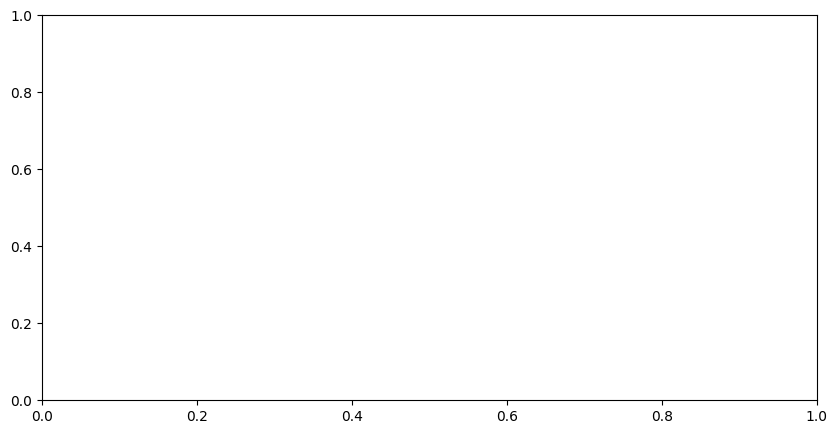

In [153]:
# plot the j-plot
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
img = ax.imshow(output_obj['intensity'], aspect='auto', origin='lower',
                cmap='seismic',
#                 vmin=0, vmax=0.7,
        extent=[mdates.date2num(pd.Timestamp(str(output_obj['time'][0]))),
                mdates.date2num(pd.Timestamp(str(output_obj['time'][-1]))),
                output_obj['distance'][0,:][0],
                output_obj['distance'][0,:][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument']} {output_obj['detector']} Intensity Along the Slit")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_xlim(left=pd.Timestamp(f"{output_obj['map_obj'].meta['date-obs'].split('T')[0]} 16:46"),
#             right=pd.Timestamp(f"{output_obj['map_obj'].meta['date-obs'].split('T')[0]} 18:30"))
# ax.set_ylim(top=510, bottom=250)
fig.colorbar(img, pad=0.02)
plt.show()

### Tracing the jet

<IPython.core.display.Javascript object>


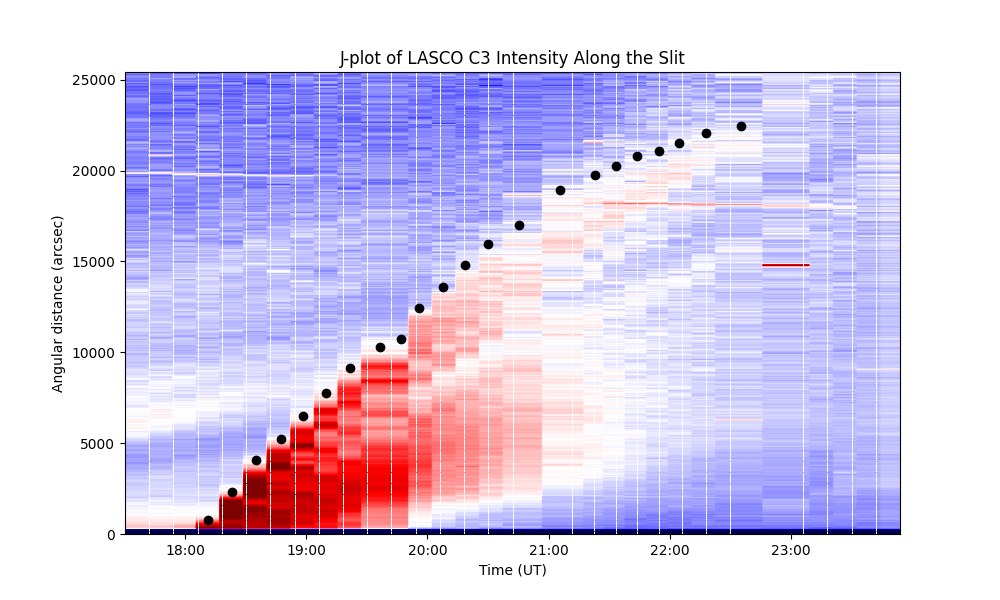

In [12]:
%matplotlib notebook

# plot the j-plot
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[mdates.date2num(pd.Timestamp(str(output_obj['time'][0]))),
                mdates.date2num(pd.Timestamp(str(output_obj['time'][-1]))),
                output_obj['distance'][0,:][0],
                output_obj['distance'][0,:][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

for col in datenum_arr:
    ax.axvline(x=col, color='w', linewidth=0.5, linestyle='--')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument']} {output_obj['detector']} Intensity Along the Slit")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# List to store coordinates
feature_coords_slit = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            feature_coords_slit.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [13]:
df_jplot = pd.DataFrame(feature_coords_slit, columns=['time','distance'])
df_jplot

,time,distance
0,19857.757661,760.988980
1,19857.765919,2301.884179
2,19857.774177,4062.907264
3,19857.782779,5218.578664
4,19857.790349,6484.314006
5,19857.798263,7750.049349
6,19857.806521,9125.848634
7,19857.816844,10281.520034
8,19857.824069,10721.775805
9,19857.830263,12427.766919


In [14]:
df_jplot.to_pickle(f"{data_dir}/jplot_data_{output_obj['instrument']}_{output_obj['detector']}_{output_obj['time'][0].split(' ')[0]}_event{event_num}.csv")
print(f"J-plot data saved at: {data_dir}/jplot_data_{output_obj['instrument']}_{output_obj['detector']}_{output_obj['time'][0].split(' ')[0]}_event{event_num}.csv")

J-plot data saved at: /home/mnedal/data/jplot_data_LASCO_C3_2024-05-14_event2.csv


### Fitting the points

In [15]:
# Extract time and distance arrays from the selected coordinates
times_f, distances = zip(*feature_coords_slit)

# Convert times to matplotlib date numbers
times_num = np.array(times_f)

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/output_obj['map_obj'].rsun_obs
print(conversion_factor)

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.1410595927183 km / arcsec


In [16]:
# convert distance from arcsec to km
df_jplot['distance_km'] = df_jplot['distance'] * conversion_factor

# calculate the distance difference in km
df_jplot['distance_diff_km'] = df_jplot['distance_km'].diff()

# convert time to datetime format
df_jplot['datetime'] = [mdates.num2date(t) for t in df_jplot['time']]

# calculate the time difference in seconds
df_jplot['time_diff_s'] = df_jplot['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df_jplot['speed_km_s'] = df_jplot['distance_diff_km'] / df_jplot['time_diff_s']

# drop the first row which will have NaN values for the differences
df_jplot.dropna(inplace=True)

In [17]:
df_jplot

,time,distance,distance_km,distance_diff_km,datetime,time_diff_s,speed_km_s
1,19857.765919,2301.884179,1.687606e+06,1.129694e+06,2024-05-14 18:22:55.382162+00:00,713.497486,1583.318178
2,19857.774177,4062.907264,2.978684e+06,1.291078e+06,2024-05-14 18:34:48.879649+00:00,713.497487,1809.506486
3,19857.782779,5218.578664,3.825954e+06,8.472702e+05,2024-05-14 18:47:12.106197+00:00,743.226548,1139.989088
4,19857.790349,6484.314006,4.753917e+06,9.279626e+05,2024-05-14 18:58:06.145560+00:00,654.039363,1418.817586
5,19857.798263,7750.049349,5.681879e+06,9.279626e+05,2024-05-14 19:09:29.913984+00:00,683.768424,1357.129867
6,19857.806521,9125.848634,6.690534e+06,1.008655e+06,2024-05-14 19:21:23.411471+00:00,713.497487,1413.676942
7,19857.816844,10281.520034,7.537804e+06,8.472702e+05,2024-05-14 19:36:15.283329+00:00,891.871858,949.990906
8,19857.824069,10721.775805,7.860574e+06,3.227696e+05,2024-05-14 19:46:39.593630+00:00,624.310301,517.001853
9,19857.830263,12427.766919,9.111306e+06,1.250732e+06,2024-05-14 19:55:34.716744+00:00,535.123114,2337.279217
10,19857.838521,13583.438319,9.958576e+06,8.472702e+05,2024-05-14 20:07:28.214231+00:00,713.497487,1187.488632


<IPython.core.display.Javascript object>


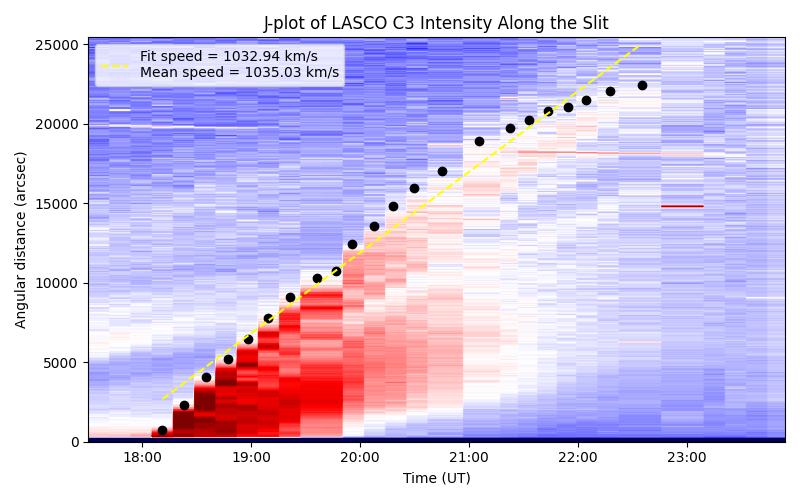

In [19]:
fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
ax.imshow(output_obj['intensity'], aspect='auto', origin='lower',
                cmap='seismic',
        extent=[mdates.date2num(pd.Timestamp(str(output_obj['time'][0]))),
                mdates.date2num(pd.Timestamp(str(output_obj['time'][-1]))),
                output_obj['distance'][0,:][0],
                output_obj['distance'][0,:][-1]])

# Add vertical lines at the borders of each column
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

# Plot the fitted line
fit_line = slope * np.array(times_num) + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s

# Plot the selected points
ax.plot(times_num, distances, 'ko')
speed = df_jplot['speed_km_s'].mean()
ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Fit speed = {speed_fit:.2f} km/s\nMean speed = {speed:.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument']} {output_obj['detector']} Intensity Along the Slit")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend()
# ax.set_ylim(top=4620)
fig.tight_layout()
plt.show()